# Introduction

This notebook uses data from the [OpenPV project](https://openpv.nrel.gov/) and the US Census to make predictions about what economic and demographic characteristics lead to installation of solar panels. The data used here was collected via the National Renewable Energy Laboratory and Census APIs and was preprocessed before use.

The data is first loaded in, and descriptive statistics are calculated.

In [1]:
# Import needed modules

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os



In [2]:
%matplotlib inline
# Create OS independent file name

subdir = os.path.join(os.path.curdir, "data")

file_path = os.path.join(subdir, "combined_data.csv")

# Read file
solar_data = pd.read_csv(file_path)

# Calculate demographic characteristics

solar_data['Percent White'] = solar_data['White Population'] / solar_data['Population']
solar_data['Percent Bachelors'] = solar_data['Bachelors Degree'] / solar_data['Population']

# Show top 20
solar_data_sorted = solar_data.sort_values('capacity', ascending=False)

solar_data_sorted.loc[:, ['combined', 'capacity']].head(20)

,combined,capacity
46,CA-Placer,1.151215e+06
37,CA-Los Angeles,8.149275e+05
12,AZ-Maricopa,8.102763e+05
50,CA-San Diego,6.734342e+05
47,CA-Riverside,4.926091e+05
278,MA-Worcester,4.135481e+05
31,CA-Fresno,4.071651e+05
18,AZ-Yuma,4.052831e+05
56,CA-Santa Clara,3.632252e+05
365,NJ-Middlesex,3.418530e+05


count    6.940000e+02
mean     2.189348e+04
std      8.524698e+04
min      3.800000e-01
25%      4.769250e+01
50%      4.267925e+02
75%      5.201544e+03
max      1.151215e+06
Name: capacity, dtype: float64


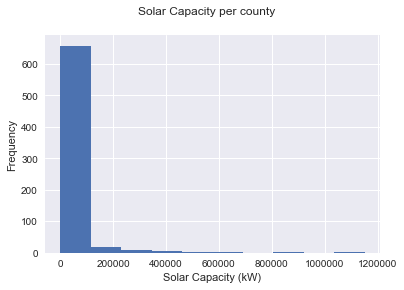

In [3]:
%matplotlib inline
# Check distribution of capacity
print(solar_data['capacity'].describe())

fig, ax = plt.subplots(1)

fig.suptitle("Solar Capacity per county")

solar_data['capacity'].plot(kind='hist', ax = ax)

ax.set_xlabel('Solar Capacity (kW)')

fig.savefig('capacity.png', fmt='png', dpi=600, bbox_inches='tight')

plt.show()

The distribution of solar capacity per county is very highly right skewed, with many counties not having much capacity with a few extreme outliers. To remove this skew, we perform a log transform on the data so that we can perform regression.

count    694.000000
mean       6.221667
std        3.101601
min       -0.967584
25%        3.864679
50%        6.056125
75%        8.556660
max       13.956328
Name: log capacity, dtype: float64


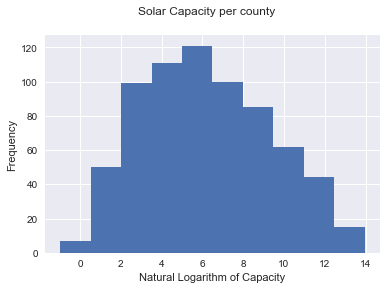

In [4]:
%matplotlib inline
# Remove skew

solar_data['log capacity'] = np.log(solar_data['capacity'].values)

# Plot and describe log transform of data

print(solar_data['log capacity'].describe())

fig, ax = plt.subplots(1)

fig.suptitle("Solar Capacity per county")

solar_data['log capacity'].plot(kind='hist', ax = ax)

ax.set_xlabel('Natural Logarithm of Capacity')

fig.savefig('logcapacity.png', fmt='png', dpi=600, bbox_inches='tight')

plt.show()

Here, the distribution is much better described by a normal distribution. Indeed, the mean and median are now much closer (6.25 and 6.10, respectively.) We now want to select predictors for our model and check their distributions. By using a log transform, we are essentially going to be performing Poisson regression. 

In [5]:
# Filter data for desired variables

solar_data_filtered = solar_data.filter(['combined', 'log capacity', 'cost', 'per_gop',
                                        'Median Age', 'Percent White', 'Percent Bachelors', 
                                        'Median Household Income', 'Median House Price', 
                                         'Tilt Irradiance'])

solar_data_filtered = solar_data_filtered.rename(columns={'cost' : 'Cost per kW', 'per_gop' : 'GOP Vote Share'})


solar_data_filtered = solar_data_filtered.loc[solar_data['Percent Bachelors'].isnull() == False, :]

In [6]:
solar_data_filtered.describe()


,log capacity,Cost per kW,GOP Vote Share,Median Age,Percent White,Percent Bachelors,Median Household Income,Median House Price,Tilt Irradiance
count,691.000000,691.000000,691.000000,691.000000,691.000000,691.000000,691.000000,691.000000,691.000000
mean,6.228632,6.669942,0.512080,38.810420,0.794650,0.122099,57013.384949,205959.623734,4.918973
std,3.105434,1.879077,0.150848,4.691513,0.146509,0.040407,14790.978905,118339.472040,0.580777
min,-0.967584,2.866667,0.041221,24.500000,0.164846,0.030531,28212.000000,55000.000000,3.530000
25%,3.872636,5.577864,0.421852,36.000000,0.725752,0.091713,46743.000000,134100.000000,4.480000
50%,6.074714,6.421209,0.527008,38.500000,0.833956,0.118790,53705.000000,167900.000000,4.830000
75%,8.562667,7.517579,0.622908,41.500000,0.904741,0.146070,63611.500000,238700.000000,5.230000
max,13.956328,24.120000,0.878105,66.500000,0.979318,0.262558,125003.000000,941400.000000,6.880000


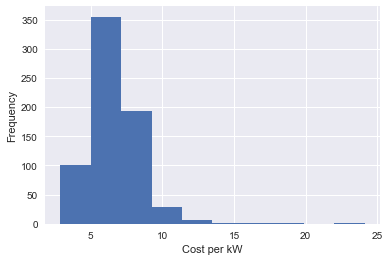

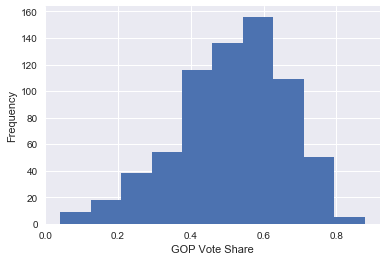

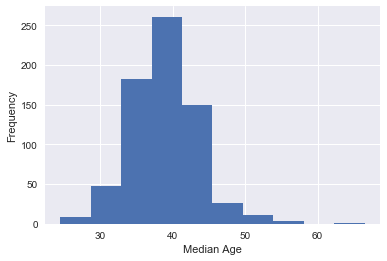

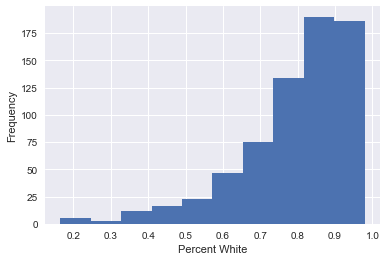

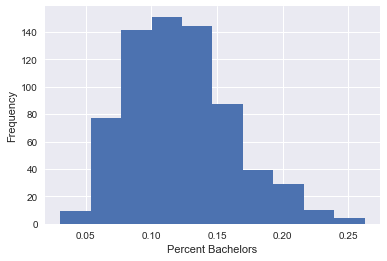

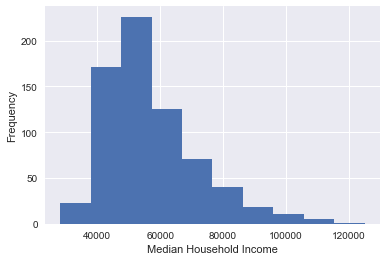

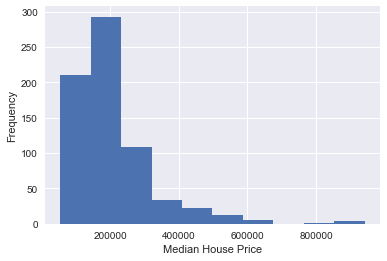

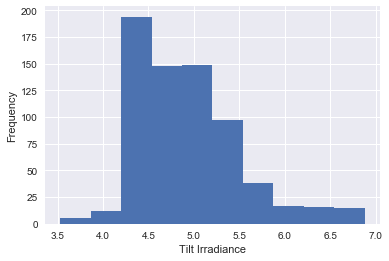

In [7]:
%matplotlib inline

columns = ['Cost per kW', 'GOP Vote Share', 'Median Age', 'Percent White', 
           'Percent Bachelors', 'Median Household Income', 'Median House Price', 
           'Tilt Irradiance']

for column in columns:
    fig, ax = plt.subplots(1)
    solar_data_filtered[column].plot(kind='hist', ax = ax)
    ax.set_xlabel(column)
    
    fig.savefig(column+'.png', fmt='png', dpi=600, bbox_inches='tight')
    
    plt.show()

In [8]:
reg_data = solar_data_filtered

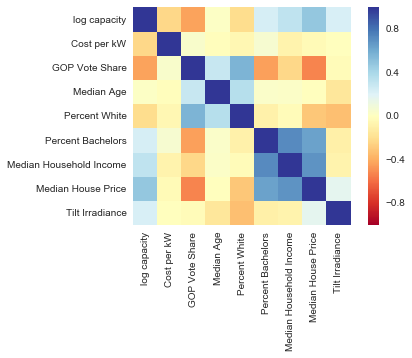

In [9]:
%matplotlib inline

sns.heatmap(reg_data.corr(), square=True, cmap='RdYlBu')

The GOP vote share in the 2016 Presidential Election, Median Age, Percentage of White People, Median Household income, and Median House Price are used as variables to predict solar capacity per capita. The heatmap above shows that each of the variables are highly intercorrelated with each other. 

## Machine learning with regression

We use the variables with machine learning in scikit-learn to find what predicts solar capacity. Since some of the variables are intercorrelated, we use regularized regression. 

In [10]:
from sklearn import model_selection
from sklearn import linear_model


# Split data into dependent and independent variables.
y = reg_data["log capacity"].values
X = reg_data.drop(["log capacity", "combined"], axis = 1).values

# Pick l1 ratio hyperparameter space

l1_space = np.linspace(0.00001, 1, 60)

# Setup cross validation and parameter search
elastic = linear_model.ElasticNetCV(l1_ratio = l1_space,
                                    normalize = True, cv = 10)

# Create train and test sets
X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y, test_size = 0.3, random_state = 21)

# Fit to the training set

elastic.fit(X_train, y_train)

# Check linear regression R^2

r2 = elastic.score(X_test, y_test)

print("Tuned ElasticNet Alpha {}".format(elastic.alpha_))
print("Tuned ElasticNet l1 ratio {}".format(elastic.l1_ratio_))
print("Tuned R squared {}".format(r2))



Tuned ElasticNet Alpha 9.566941771204195e-05
Tuned ElasticNet l1 ratio 0.7118672881355932
Tuned R squared 0.3607567042037384


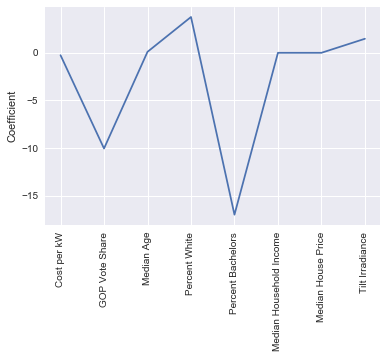

In [11]:
%matplotlib inline

elastic_coef = elastic.coef_
fig, ax = plt.subplots(1)
predictors = reg_data.drop(["log capacity", "combined"], axis = 1).columns

ax.plot(range(len(predictors)), elastic_coef)
plt.xticks(range(len(predictors)), predictors.values, rotation = 90)
ax.set_ylabel("Coefficient")

fig.savefig('coefficients.png', fmt='png', dpi=600, bbox_inches='tight')

plt.show()

From our data, it appears that solar capcity is negatively associated with Donald Trump's share of the vote in that county in the 2016 Presidential Election. Surprisingly, solar capacity is very negatively associated with the number of adults with Bachelor's degrees. Conversely, solar capacity is positively associated with higher solar irradiance, which isn't necessarily surprising since solar panels will generate more electricity in sunny areas. Solar capacity does have a slightly positive associate with the percentage of the population that is white. However, it appears that there is very little relationship with Cost per kW, Median Age, Median Household Income, or Median House Price.

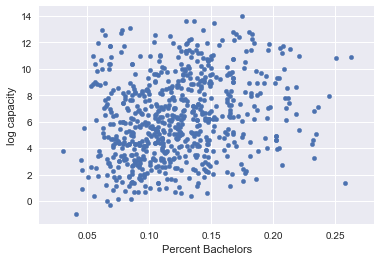

In [12]:
%matplotlib inline
fig, ax = plt.subplots(1)

solar_data_filtered.plot.scatter(x = 'Percent Bachelors', y = 'log capacity', ax = ax)



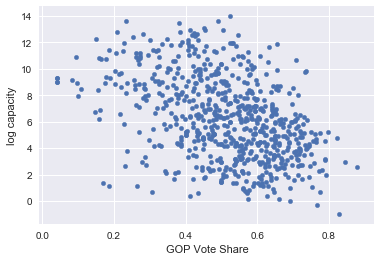

In [13]:
%matplotlib inline
fig, ax = plt.subplots(1)

reg_data.plot.scatter(x = 'GOP Vote Share', y = 'log capacity', ax = ax)

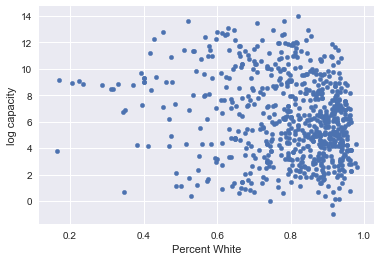

In [14]:
%matplotlib inline
fig, ax = plt.subplots(1)

solar_data_filtered.plot.scatter(x = 'Percent White', y = 'log capacity', ax = ax)

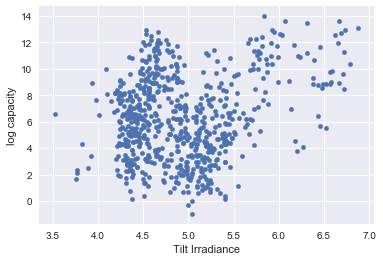

In [15]:
%matplotlib inline
fig, ax = plt.subplots(1)

solar_data_filtered.plot.scatter(x = 'Tilt Irradiance', y = 'log capacity', ax = ax)